<a href="https://colab.research.google.com/github/A1ienSword/Pattern-recognition-labs/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_6_%D0%9A%D0%BE%D1%81%D1%82%D0%B8%D1%86%D1%8B%D0%BD_%D0%92%D0%92_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №6. Оценка качества работы алгоритмов классификации и кластеризации.
1. На основе предыдущих лабораторных работ написать программу, оценивающую
результаты работы различных алгоритмов кластеризации и классификации (k-means,
kNN, SVM, максимин).
2. Необходимо реализовать следующие методы оценки:

  a) Для внешнего оценивания:
  1. Точность, отклик (полнота), F1-мера
  2. ROC-кривые
  3. Среднеквадратичная ошибка
  4. Кросс-валидация
  5. Матрица неточностей (confusion matrix)

  b) Для внутреннего оценивания:
  1. Коэффициент детерминации (R-squared для случая без известного разбиения)
  2. Коэффициент силуэта
  3. Индекс Данна (Dunn index)
  4. Индекс Девиса-Болдина (DBI)
  5. Индекс валидности по плотности кластеризации (DBCV)

3. Продемонстрировать работу программы на подготовленном наборе данных.
4. Функции, реализующие указанные способы оценки качества, должны быть
реализованы студентом самостоятельно. Допускается использование готовых
примитивов из стандартных или сторонних библиотек для выполнения базовых (в т.ч.
векторизованных) операций (сложение, умножение, возведение в степень, вычисление
среднего значения и т.п.).
5. Требования к набору данных: не менее 30 объектов, не менее 2 и не более 3 классов,
не менее 3 и не более 7 атрибутов у объекта. Можно взять предложенные наборы
данных «Ирисы» либо «Фрукты и овощи».
6. При выполнении задания рекомендуется использовать язык программирования Python
или среду Octave.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score

In [ ]:
def k_means(X, n_clusters=3, max_iter=300, tol=1e-4):
    """
    Реализация алгоритма k-средних

    Параметры:
    X - нормализованные данные
    n_clusters - количество кластеров
    max_iter - максимальное количество итераций
    tol - допустимое изменение для остановки
    """
    # Инициализация центроидов случайными точками
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]

    for _ in range(max_iter):
        # Назначение кластеров
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Обновление центроидов
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])

        # Проверка сходимости
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels


In [ ]:
def maximin_cluster(data, max_clusters=100, threshold_mult=0.7):
    """
    Реализация алгоритма максимина для кластеризации.

    Параметры:
    ----------
    data - Массив данных для кластеризации (n_samples, n_features)
    max_clusters - Максимальное количество кластеров
    threshold_mult - Множитель для порога
    """
    n_samples = data.shape[0]

    # Инициализация - первый центр - случайный
    centers = [data[np.random.randint(0, n_samples)].copy()]
    labels = np.zeros(n_samples, dtype=int)

    # Находим самый удаленный объект от первого центра
    distances = np.linalg.norm(data - centers[0], axis=1)
    farthest_idx = np.argmax(distances)
    centers.append(data[farthest_idx].copy())

    # Вычисляем порог
    threshold = threshold_mult * np.linalg.norm(centers[0] - centers[1])


    changed = True
    while changed and len(centers) < max_clusters:
        changed = False

        # Вычисляем расстояния до ближайших центров
        min_distances = np.full(n_samples, np.inf)
        for i, center in enumerate(centers):
            dist = np.linalg.norm(data - center, axis=1)
            min_distances = np.minimum(min_distances, dist)

        # Находим максимальное минимальное расстояние
        max_min_dist = np.max(min_distances)
        farthest_idx = np.argmax(min_distances)

        # Проверяем условие добавления нового центра
        if max_min_dist > threshold:
            centers.append(data[farthest_idx].copy())
            threshold = threshold_mult * max_min_dist
            changed = True

    #назначаем объекты к ближайшим центрам
    for i in range(n_samples):
        dists = [np.linalg.norm(data[i] - c) for c in centers]
        labels[i] = np.argmin(dists)

    return np.array(labels), centers

In [ ]:
def euclidean_distance(x1, x2):
    """
    Вычисляет евклидово расстояние между двумя точками.

    Параметры:
    - x1, x2 (numpy.ndarray): Векторы признаков.

    Возвращает:
    - float: Расстояние между векторами.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))


In [ ]:
def kNN_predict(X_train, y_train, X_test, k=3):
    """
    Реализация алгоритма k ближайших соседей.

    Параметры:
    - X_train: Обучающие данные.
    - y_train: Метки обучающих данных.
    - X_test: Тестовые данные.
    - k: Количество соседей.

    Возвращает:
    - predictions: Предсказанные метки для тестовых данных.
    """
    predictions = []
    for test_point in X_test:
        distances = [euclidean_distance(test_point, x) for x in X_train]
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]
        most_common = Counter(k_labels).most_common(1)
        predictions.append(most_common[0][0])
    return np.array(predictions)


In [ ]:
def evaluate_model(X_train, y_train, X_test, y_test, k):
    """
    Функция для оценки точности модели.

    Параметры:
    - X_train: Обучающие данные.
    - y_train: Метки обучающих данных.
    - X_test: Тестовые данные.
    - y_test: Метки тестовых данных.
    - k: Количество соседей.

    Возвращает:
    - accuracy: точность модели.
    """
    y_pred = kNN_predict(X_train, y_train, X_test, k=k)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [ ]:
def train_svm(X, y, C=1.0, learning_rate=0.001, iterations=1000, verbose=False):
    """
    Обучение бинарного классификатора SVM с мягким зазором.

    Параметры:
    X - признаки обучающей выборки
    y - метки классов (1 и -1)
    C - параметр регуляризации
    learning_rate - скорость обучения
    iterations - количество итераций
    verbose - вывод потерь в процессе обучения
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0.0

    for it in range(iterations):
        scores = np.dot(X, w) + b
        y_pred = y * scores
        hinge_loss = np.maximum(0, 1 - y_pred)
        loss = 0.5 * np.dot(w, w) + C * np.sum(hinge_loss)

        mask = hinge_loss > 0

        if np.sum(mask) == 0:
            grad_w = w
            grad_b = 0
        else:
            grad_w = w - C * np.dot(X[mask].T, y[mask])
            grad_b = -C * np.sum(y[mask])

        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if verbose and (it % 100 == 0):
            print(f'Итерация {it}, Потери: {loss:.4f}')

    return w, b



## Для внешнего оценивания

### Точность, отклик (полнота), F1-мера

In [ ]:
def calculate_precision_recall_f1(y_true, y_pred):
    """
    Вычисляет точность, полноту и F1-меру для бинарной классификации

    Параметры:
    y_true - истинные метки классов
    y_pred - предсказанные метки классов

    Возвращает:
    precision, recall, f1 - точность, полнота и F1-мера
    """
    # Создаем функции для многоклассовой классификации
    classes = np.unique(y_true)
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for cls in classes:
        true_positives = np.sum((y_true == cls) & (y_pred == cls))
        false_positives = np.sum((y_true != cls) & (y_pred == cls))
        false_negatives = np.sum((y_true == cls) & (y_pred != cls))

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)

    # Вычисляем макро-средние значения
    macro_precision = np.mean(precision_per_class)
    macro_recall = np.mean(recall_per_class)
    macro_f1 = np.mean(f1_per_class)

    return macro_precision, macro_recall, macro_f1


### ROC-кривые

In [ ]:
def plot_roc_curve(y_true, y_score):
    """
    Строит ROC-кривую и вычисляет AUC

    Параметры:
    y_true - истинные метки классов (бинарные)
    y_score - вероятности или оценки принадлежности к положительному классу

    Возвращает:
    auc - площадь под ROC-кривой
    """
    # Сортируем по убыванию вероятностей
    indices = np.argsort(y_score)[::-1]
    y_true_sorted = y_true[indices]

    # Для построения ROC-кривой нам нужны TPR и FPR
    n_positive = np.sum(y_true == 1)
    n_negative = len(y_true) - n_positive

    tpr = np.zeros(len(y_true) + 1)
    fpr = np.zeros(len(y_true) + 1)

    tp_count = 0
    fp_count = 0

    # Первая точка (0,0)
    for i in range(len(y_true)):
        if y_true_sorted[i] == 1:
            tp_count += 1
        else:
            fp_count += 1

        tpr[i+1] = tp_count / n_positive
        fpr[i+1] = fp_count / n_negative

    # Вычисляем AUC
    auc = np.trapz(tpr, fpr)

    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Случайная классификация')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.grid(True)

    return auc

### Среднеквадратичная ошибка

In [ ]:
def mean_squared_error(y_true, y_pred):
    """
    Вычисляет среднеквадратичную ошибку

    Параметры:
    y_true - истинные значения
    y_pred - предсказанные значения

    Возвращает:
    mse - среднеквадратичная ошибка
    """
    return np.mean((y_true - y_pred) ** 2)


### Кросс-валидация

In [ ]:
def k_fold_cross_validation(X, y, model_func, n_splits=5):
    """
    Выполняет k-fold кросс-валидацию

    Параметры:
    X - признаки
    y - метки классов
    model_func - функция, реализующая модель (должна принимать X_train, y_train, X_test и возвращать y_pred)
    n_splits - количество разбиений

    Возвращает:
    mean_score - средняя метрика качества
    scores - список метрик для каждого разбиения
    """
    # Создаем индексы для разбиения
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    current = 0
    test_indices = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices.append(indices[start:stop])
        current = stop

    # Выполняем кросс-валидацию
    scores = []
    for i in range(n_splits):
        test_idx = test_indices[i]
        train_idx = np.concatenate([test_indices[j] for j in range(n_splits) if j != i])

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_pred = model_func(X_train, y_train, X_test)

        precision, recall, f1 = calculate_precision_recall_f1(y_test, y_pred)
        scores.append(f1)  # Используем F1-меру в качестве метрики

    return np.mean(scores), scores


### Матрица неточностей (confusion matrix)

In [ ]:
def confusion_matrix(y_true, y_pred):
    """
    Вычисляет матрицу неточностей

    Параметры:
    y_true - истинные метки классов
    y_pred - предсказанные метки классов

    Возвращает:
    cm - матрица неточностей
    """
    classes = np.unique(np.concatenate((y_true, y_pred)))
    n_classes = len(classes)

    # Создаем пустую матрицу неточностей
    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Заполняем матрицу
    for i in range(len(y_true)):
        true_idx = np.where(classes == y_true[i])[0][0]
        pred_idx = np.where(classes == y_pred[i])[0][0]
        cm[true_idx, pred_idx] += 1

    return cm, classes

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Строит матрицу неточностей

    Параметры:
    y_true - истинные метки классов
    y_pred - предсказанные метки классов
    """
    cm, classes = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Матрица неточностей')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')

    # Добавляем значения в ячейки
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='white' if cm[i, j] > np.max(cm)/2 else 'black')

    plt.tight_layout()


## Для внутреннего оценивания


### Коэффициент детерминации (R-squared для случая без известного разбиения)

In [ ]:
def r_squared(X, labels, centroids):
    """
    Вычисляет коэффициент детерминации для кластеризации

    Параметры:
    X - данные
    labels - метки кластеров
    centroids - центроиды кластеров

    Возвращает:
    r2 - коэффициент детерминации
    """
    # Общая дисперсия (отклонение от общего среднего)
    overall_mean = np.mean(X, axis=0)
    total_variance = np.sum(np.sum((X - overall_mean) ** 2, axis=1))

    # Внутрикластерная дисперсия
    within_variance = 0

    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            within_variance += np.sum(np.sum((cluster_points - centroids[i]) ** 2, axis=1))

    # Коэффициент детерминации
    r2 = 1 - (within_variance / total_variance)

    return r2


### Коэффициент силуэта

In [ ]:
def silhouette_coefficient(X, labels):
    """
    Вычисляет коэффициент силуэта для кластеризации

    Параметры:
    X - данные
    labels - метки кластеров

    Возвращает:
    silhouette_avg - средний коэффициент силуэта
    silhouette_samples - коэффициенты силуэта для каждого объекта
    """
    n_samples = X.shape[0]
    n_clusters = len(np.unique(labels))

    # Предварительные проверки
    if n_clusters <= 1 or n_clusters >= n_samples:
        return 0, np.zeros(n_samples)

    # Вычисляем расстояние между всеми точками
    distances = pairwise_distances(X)

    silhouette_samples = np.zeros(n_samples)

    for i in range(n_samples):
        # Получаем метку кластера для текущей точки
        current_cluster = labels[i]

        # Индексы точек того же кластера (исключая текущую точку)
        same_cluster_indices = np.where(labels == current_cluster)[0]
        same_cluster_indices = same_cluster_indices[same_cluster_indices != i]

        if len(same_cluster_indices) == 0:  # Если точка одна в кластере
            silhouette_samples[i] = 0
            continue

        # Среднее расстояние до точек того же кластера (a)
        a = np.mean(distances[i, same_cluster_indices])

        # Среднее расстояние до точек других кластеров
        b_values = []
        for cluster in np.unique(labels):
            if cluster != current_cluster:
                other_cluster_indices = np.where(labels == cluster)[0]
                if len(other_cluster_indices) > 0:
                    mean_distance = np.mean(distances[i, other_cluster_indices])
                    b_values.append(mean_distance)

        if not b_values:  # Если только один кластер
            silhouette_samples[i] = 0
            continue

        # Ближайший другой кластер (b)
        b = min(b_values)

        # Вычисляем коэффициент силуэта
        silhouette_samples[i] = (b - a) / max(a, b)

    silhouette_avg = np.mean(silhouette_samples)

    return silhouette_avg, silhouette_samples


### Индекс Данна (Dunn index)


In [ ]:
def dunn_index(X, labels, centroids):
    """
    Вычисляет индекс Данна для кластеризации

    Параметры:
    X - данные
    labels - метки кластеров
    centroids - центроиды кластеров

    Возвращает:
    dunn - индекс Данна
    """
    n_clusters = len(centroids)

    # Вычисляем минимальное межкластерное расстояние
    min_inter_cluster_dist = float('inf')
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            dist = np.linalg.norm(centroids[i] - centroids[j])
            min_inter_cluster_dist = min(min_inter_cluster_dist, dist)

    # Вычисляем максимальный диаметр кластера
    max_intra_cluster_dist = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:  # Нужно минимум 2 точки для расчета расстояний
            # Вычисляем попарные расстояния внутри кластера
            dists = pairwise_distances(cluster_points)
            max_intra_cluster_dist = max(max_intra_cluster_dist, np.max(dists))

    if max_intra_cluster_dist == 0:
        return float('inf')  # Избегаем деления на ноль

    dunn = min_inter_cluster_dist / max_intra_cluster_dist

    return dunn


### Индекс Девиса-Болдина (DBI)

In [ ]:
def davis_bouldin_index(X, labels, centroids):
    """
    Вычисляет индекс Дэвиса-Болдина для кластеризации

    Параметры:
    X - данные
    labels - метки кластеров
    centroids - центроиды кластеров

    Возвращает:
    dbi - индекс Дэвиса-Болдина
    """
    n_clusters = len(centroids)

    if n_clusters <= 1:
        return 0.0

    # Вычисляем разброс внутри каждого кластера
    cluster_dispersion = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            # Среднее расстояние от точек до центроида
            distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
            cluster_dispersion[i] = np.mean(distances)

    # Вычисляем индекс Дэвиса-Болдина
    db_values = np.zeros(n_clusters)
    for i in range(n_clusters):
        max_ratio = 0
        for j in range(n_clusters):
            if i != j:
                # Расстояние между центроидами
                centroid_distance = np.linalg.norm(centroids[i] - centroids[j])
                if centroid_distance > 0:  # Избегаем деления на ноль
                    ratio = (cluster_dispersion[i] + cluster_dispersion[j]) / centroid_distance
                    max_ratio = max(max_ratio, ratio)
        db_values[i] = max_ratio

    dbi = np.mean(db_values)

    return dbi


### Индекс валидности по плотности кластеризации (DBCV)


In [ ]:
def calculate_density(X, point_idx, k=7):
    """
    Вычисляет плотность для точки

    Параметры:
    X - данные
    point_idx - индекс точки
    k - количество соседей для расчета плотности

    Возвращает:
    density - плотность
    """
    distances = np.linalg.norm(X - X[point_idx], axis=1)
    distances.sort()

    # Используем k-ое ближайшее расстояние для оценки плотности
    if k < len(distances):
        density = 1.0 / distances[k]
    else:
        density = 1.0 / distances[-1]

    return density



In [ ]:
def density_based_clustering_validation(X, labels):
    """
    Вычисляет индекс валидности по плотности кластеризации

    Параметры:
    X - данные
    labels - метки кластеров

    Возвращает:
    dbcv - индекс валидности
    """
    n_samples = X.shape[0]
    n_clusters = len(np.unique(labels))

    if n_clusters <= 1 or n_clusters >= n_samples:
        return 0.0

    # Вычисляем плотность для каждой точки
    densities = np.zeros(n_samples)
    for i in range(n_samples):
        densities[i] = calculate_density(X, i)

    # Вычисляем среднюю плотность для каждого кластера
    cluster_densities = np.zeros(n_clusters)
    for i, cluster in enumerate(np.unique(labels)):
        cluster_points = np.where(labels == cluster)[0]
        cluster_densities[i] = np.mean(densities[cluster_points])

    # Вычисляем плотность между кластерами
    inter_cluster_densities = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i_points = X[labels == i]
            cluster_j_points = X[labels == j]

            # Находим точки с минимальным расстоянием между кластерами
            min_density = 0

            for idx_i, point_i in enumerate(cluster_i_points):
                for idx_j, point_j in enumerate(cluster_j_points):
                    dist = np.linalg.norm(point_i - point_j)
                    density = 1.0 / dist if dist > 0 else float('inf')
                    min_density = max(min_density, density)

            inter_cluster_densities[i, j] = min_density
            inter_cluster_densities[j, i] = min_density

    # Вычисляем валидность по плотности
    dbcv = 0
    for i in range(n_clusters):
        max_inter_density = 0
        for j in range(n_clusters):
            if i != j:
                max_inter_density = max(max_inter_density, inter_cluster_densities[i, j])

        if max_inter_density > 0 and cluster_densities[i] > 0:
            # Мера разделимости
            separation = cluster_densities[i] / max_inter_density
            dbcv += np.log(separation)

    dbcv /= n_clusters

    return dbcv


## Демонстрация работы программы

In [ ]:
# Загрузка данных
data = pd.read_csv('iris.csv.gz')

In [ ]:
# Разделение данных на признаки (X) и метки классов (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [ ]:
# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Преобразование меток в числовые
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### k-means

Внутренние метрики для k-means:
Коэффициент силуэта: 0.462
Индекс Данна: 0.361
Индекс Дэвиса-Болдина: 0.834
Коэффициент детерминации: 0.765
DBCV: -0.117

Внешние метрики (сравнение с истинными метками):
Точность: 0.250
Полнота: 0.220
F1-мера: 0.234


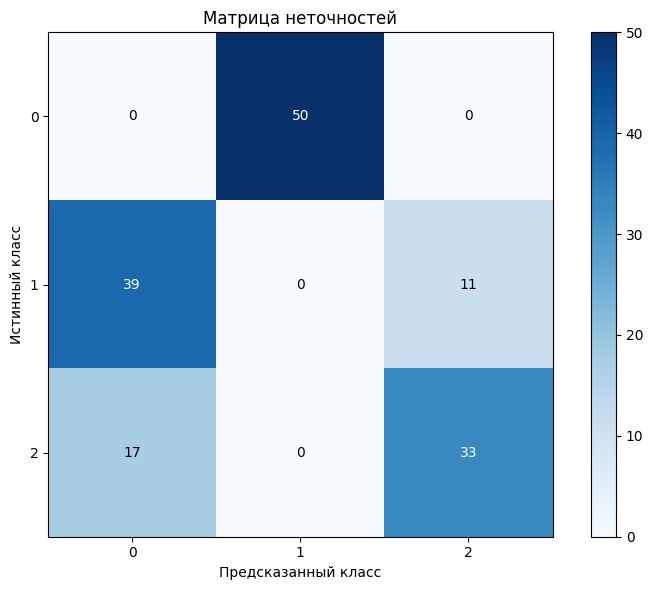

AUC: 1.000


<ipython-input-19-1fe4dd500200>:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


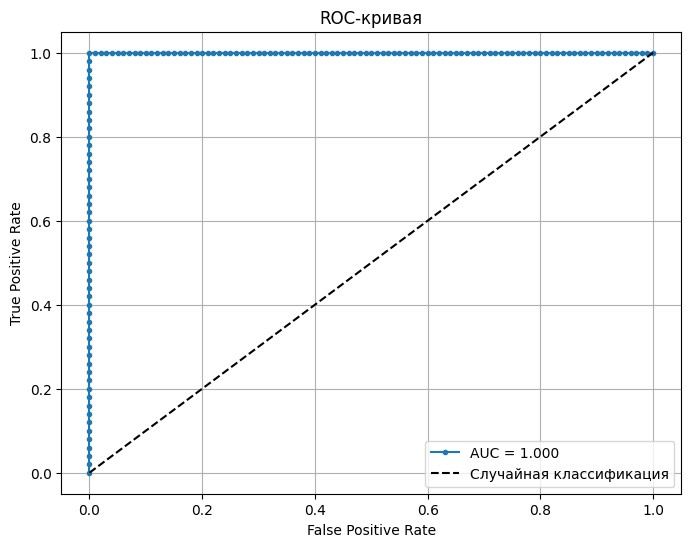


Средняя F1-мера по кросс-валидации для kNN: 0.954
F1-меры по фолдам: ['0.957', '0.970', '0.909', '1.000', '0.933']


In [ ]:
# Применение алгоритма k-means
centroids, labels = k_means(X_scaled, n_clusters=3)

# Оценка внутренних метрик
print("Внутренние метрики для k-means:")
silhouette_avg, _ = silhouette_coefficient(X_scaled, labels)
print(f"Коэффициент силуэта: {silhouette_avg:.3f}")

dunn = dunn_index(X_scaled, labels, centroids)
print(f"Индекс Данна: {dunn:.3f}")

dbi = davis_bouldin_index(X_scaled, labels, centroids)
print(f"Индекс Дэвиса-Болдина: {dbi:.3f}")

r2 = r_squared(X_scaled, labels, centroids)
print(f"Коэффициент детерминации: {r2:.3f}")

dbcv = density_based_clustering_validation(X_scaled, labels)
print(f"DBCV: {dbcv:.3f}")

# Оценка внешних метрик
print("\nВнешние метрики (сравнение с истинными метками):")
precision, recall, f1 = calculate_precision_recall_f1(y, labels)
print(f"Точность: {precision:.3f}")
print(f"Полнота: {recall:.3f}")
print(f"F1-мера: {f1:.3f}")

# Построение матрицы неточностей
plot_confusion_matrix(y, labels)
plt.show()

# Обучение SVM для демонстрации ROC-кривой
# Преобразуем в бинарную задачу (класс 0 против остальных)
y_binary = np.where(y == 0, 1, 0)
w, b = train_svm(X_scaled, y_binary * 2 - 1)  # Преобразуем к {-1, 1}

# Получаем оценки для ROC-кривой
scores = np.dot(X_scaled, w) + b

# Строим ROC-кривую
auc = plot_roc_curve(y_binary, scores)
print(f"AUC: {auc:.3f}")
plt.show()

# Кросс-валидация для kNN
def knn_model(X_train, y_train, X_test, k=3):
    return kNN_predict(X_train, y_train, X_test, k)

mean_score, scores = k_fold_cross_validation(X_scaled, y, lambda X_train, y_train, X_test: knn_model(X_train, y_train, X_test), n_splits=5)
print(f"\nСредняя F1-мера по кросс-валидации для kNN: {mean_score:.3f}")
print(f"F1-меры по фолдам: {[f'{s:.3f}' for s in scores]}")


### kNN

### SVM

### максимин